In [1]:
import os
import sys
import torch
import pandas as pd
from tqdm.notebook import tqdm
import pickle as pk
import numpy as np

device = torch.cuda.set_device(0)

BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [2]:
#embedding_analysis_best_model = "Bindingdb_SimpleCosine_Morgan_ESM_DSCRIPT_cat_rep0_best_model.sav"
model = torch.load(f"{MODEL_BASE_DIR}/BindingDB_ProtBert_Morgan_progressiveMargin_DUDeWithin_best_model.sav").eval().cuda()

In [3]:
model

SimpleCosine(
  (mol_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (prot_projector): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (activator): Cosine()
)

In [6]:
df = pd.read_csv(f"{BASE_DIR}/dataset/BindingDB/test.csv",index_col=0,header=0)

In [8]:
from src.prot_feats import ProtBert_f
from src.mol_feats import Morgan_f

In [10]:
prot_f = ProtBert_f()
mol_f = Morgan_f()

In [13]:
prot_f.precompute(df['Target Sequence'],to_disk_path='../saved_embeddings/bindingdb',from_disk=True)
mol_f.precompute(df['SMILES'],to_disk_path='../saved_embeddings/bindingdb',from_disk=True)

--- precomputing ProtBert protein featurizer ---
--- loading from disk ---
--- precomputing morgan molecule featurizer ---
--- loading from disk ---


In [15]:
preds = []
for _, (sm, seq, lab, _, _) in tqdm(df.iterrows(),total=len(df)):
    preds.append(model(mol_f(sm).unsqueeze(0).cuda(), prot_f(seq).unsqueeze(0).cuda()).detach().cpu().numpy())

  0%|          | 0/13289 [00:00<?, ?it/s]

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
print(f"Model: {average_precision_score(df['Label'], preds)}")

Model: 0.6527861921531386


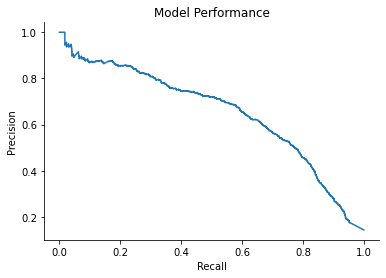

In [19]:
pr, rec, thr = precision_recall_curve(df['Label'], preds)
plt.plot(rec, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model Performance')
sns.despine()
plt.show()

In [20]:
molecules = df['SMILES'].unique()
sequences = df['Target Sequence'].unique()

In [22]:
mol_embeddings = []
prot_embeddings = []

with torch.no_grad():
    for m in tqdm(molecules):
        mol_embeddings.append(model.mol_projector(mol_f(m).cuda()))
    for p in tqdm(sequences):
        prot_embeddings.append(model.prot_projector(prot_f(p).cuda()))
        
all_embeddings = torch.cat([torch.stack(mol_embeddings,0),torch.stack(prot_embeddings,0)],0).detach().cpu().numpy()
pk.dump(all_embeddings,open(f'{DATA_DIR}/protbert_morgan_bindingdb_embeddings.pk','wb'))

  0%|          | 0/3321 [00:00<?, ?it/s]

  0%|          | 0/981 [00:00<?, ?it/s]

In [23]:
all_embeddings = pk.load(open(f'{DATA_DIR}/protbert_morgan_bindingdb_embeddings.pk','rb'))

In [36]:
import umap
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
distance_matrix = pairwise_distances(all_embeddings, all_embeddings, metric='cosine', n_jobs=-1)

In [26]:
# emb_points = UMAP(random_state=42,metric='cosine').fit_transform(all_embeddings)
# emb_points = PCA(n_components=2).fit_transform(all_embeddings)
emb_points = TSNE(metric="precomputed").fit_transform(distance_matrix)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [27]:
pos_df = df[df['Label'] == 1]

In [28]:
edge_list = []
for i, m in tqdm(enumerate(molecules),total=len(molecules)):
    for p in pos_df[pos_df['SMILES'] == m]['Target Sequence'].unique():
        edge_list.append(tuple([i, list(sequences).index(p)+len(molecules)]))
# for i, p in tqdm(enumerate(sequences),total=len(sequences)):
#     for m in test_df[test_df['Target Sequence'] == p]['SMILES'].unique():
#         edge_list.append(tuple([list(molecules).index(m),i+len(molecules)]))

  0%|          | 0/3321 [00:00<?, ?it/s]

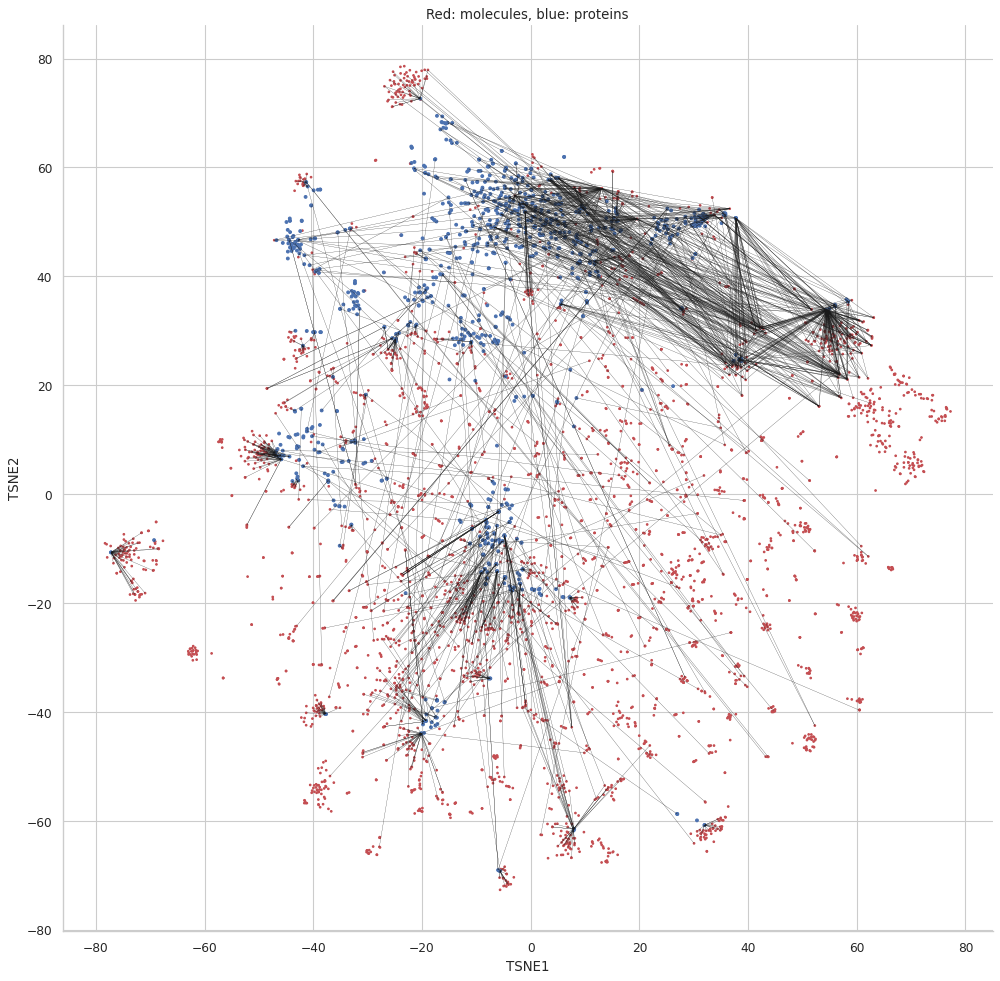

In [35]:
sns.set(style = "whitegrid")
arrow_locs = np.array([(*emb_points[midx], *(emb_points[pidx] - emb_points[midx])) for (midx, pidx) in edge_list])
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(list(emb_points[:,0]),list(emb_points[:,1]),c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ],s=[2 if i < len(molecules) else 6 for i in range(all_embeddings.shape[0]) ])
plt.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],angles='xy', scale_units='xy', scale=1,width=0.00025)
sns.despine()
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Red: molecules, blue: proteins')
# plt.savefig('embedding_analysis/esm_dscript_cat_bindingdb_tsne.png',bbox_inches='tight')
plt.show()

---

In [30]:
tsne_3d = TSNE(n_components=3, random_state=0, metric="precomputed")
projections = tsne_3d.fit_transform(distance_matrix)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


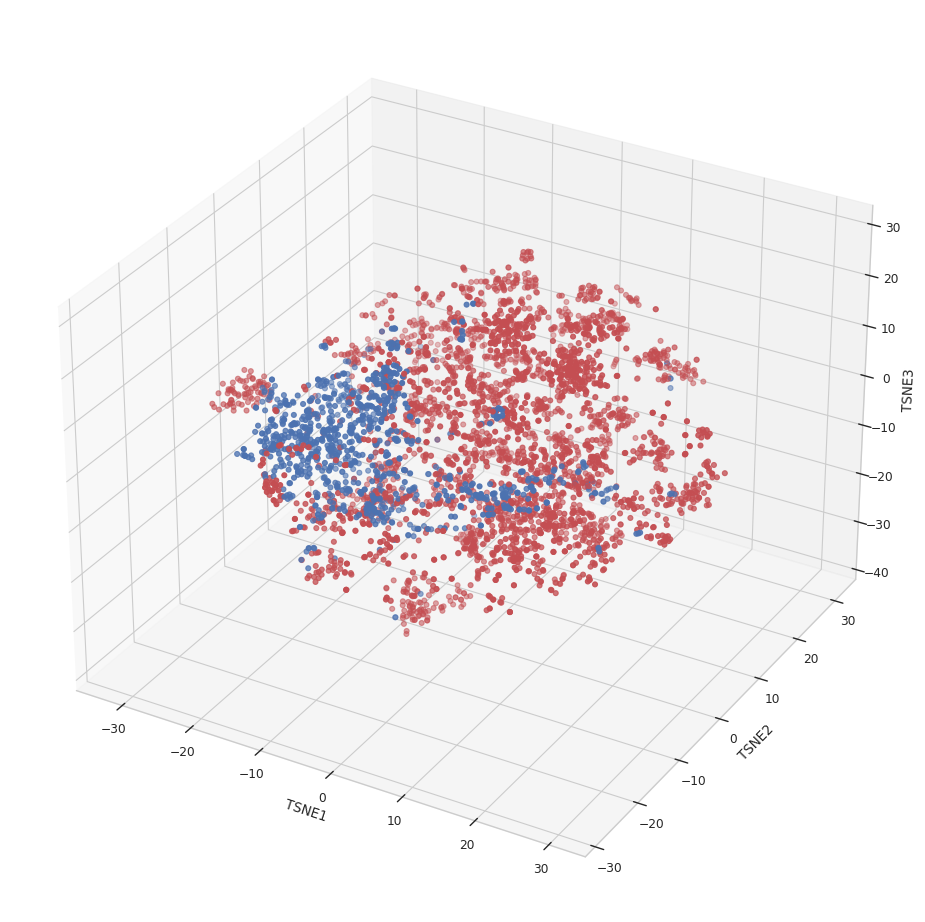

In [31]:
%matplotlib inline
arrow_locs = np.array([(*projections[midx], *(projections[pidx] - projections[midx])) for (midx, pidx) in edge_list])
sns.set(style = "whitegrid")
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = projections[:,0]
y = projections[:,1]
z = projections[:,2]

ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")

ax.scatter(x, y, z, c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ])
# ax.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],arrow_locs[:,4],arrow_locs[:,5],angles='xyz', scale_units='xyz', scale=1,width=0.00025)

plt.show()

---

In [32]:
umap_points = UMAP(metric='precomputed').fit_transform(distance_matrix)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


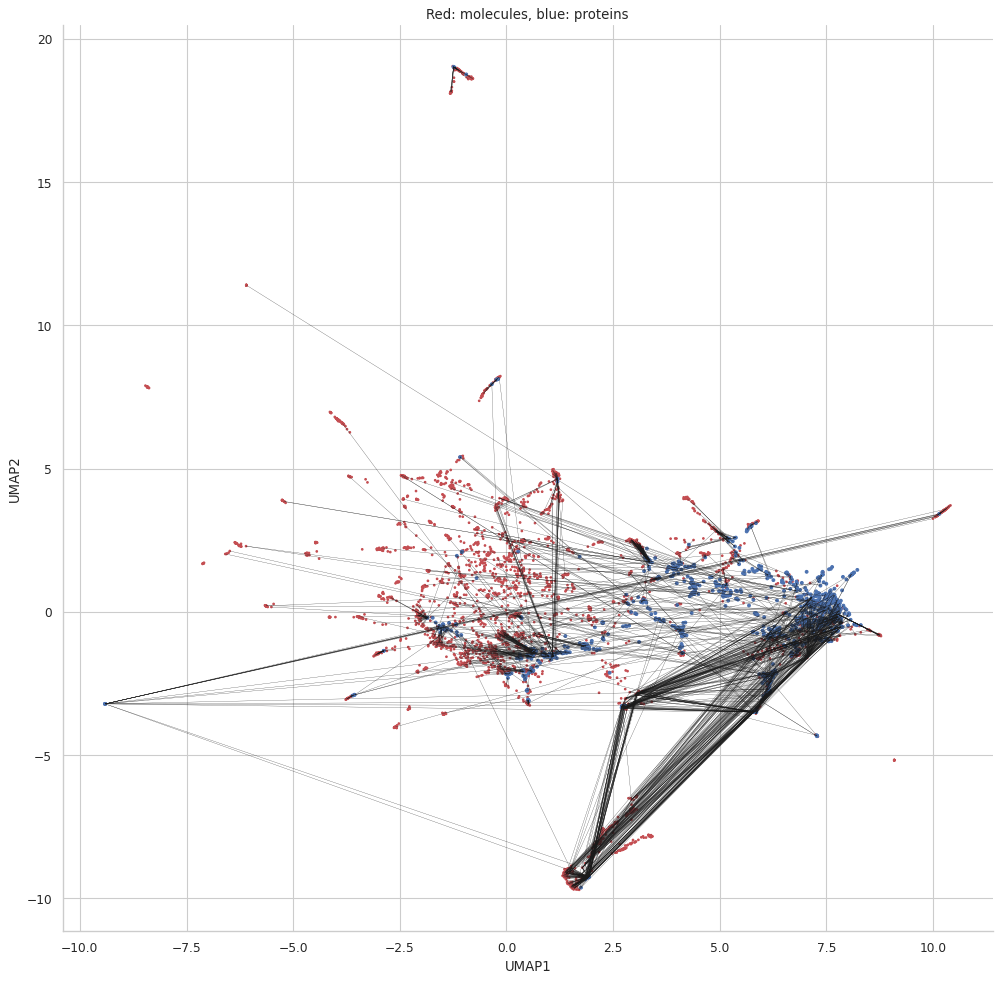

In [33]:
arrow_locs = np.array([(*umap_points[midx], *(umap_points[pidx] - umap_points[midx])) for (midx, pidx) in edge_list])
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(list(umap_points[:,0]),list(umap_points[:,1]),c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ],s=[2 if i < len(molecules) else 6 for i in range(all_embeddings.shape[0]) ])
plt.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],angles='xy', scale_units='xy', scale=1,width=0.00025)
sns.despine()
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Red: molecules, blue: proteins')
# plt.savefig('embedding_analysis/esm_dscript_cat_bindingdb_umap.png',bbox_inches='tight')
plt.show()